<a href="https://colab.research.google.com/github/KenzioDG/Colab-Projects/blob/main/Unet_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmenting Images with Unet Architecture

Unet models are very suitable for image segmentation because it does computation on a pixel-wise output, it does exceptionally well when there are fewer mask/training data. It is very often used in the field of medicine and biology, (segmentation for X-ray detection, MRI and such), it can be modified for tasks other than segmentation but really it is mainly fitted for image segmentation.

For the sake of simplicity i decided to implement a U-net code due to the fact that it needs no modifications for this task.

*   U-Net is a fully convolutional neural network (CNN), which means that it only uses convolutions and pooling operations. This makes it very efficient to train and deploy.
*   U-Net has a unique encoder-decoder architecture. The encoder path extracts features from the input image, and the decoder path reconstructs the image while preserving the extracted features. This allows U-Net to learn both global and local context in the image, which is essential for accurate segmentation.
*   U-Net is very flexible and can be modified to perform a variety of image segmentation tasks, such as semantic segmentation, instance segmentation, and panoptic segmentation. in this case it may be utilized to segment aerial images.




In [ ]:
pip install gdown

In [1]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

random.seed(69)

# Data Preparation

This is a function that is used to resize our images

In [2]:
def img_resize(image, y_dim, x_dim):
    resized_img = cv2.resize(image, (y_dim,x_dim))
    return resized_img

In [3]:
import gdown

# Get the file ID from the Drive link.
file_id = "1GK3k90UV2KVfazD9f1-VA_0M-VjGl6Ut"

# Download the file.
!gdown 1GK3k90UV2KVfazD9f1-VA_0M-VjGl6Ut


Downloading...
From: https://drive.google.com/uc?id=1GK3k90UV2KVfazD9f1-VA_0M-VjGl6Ut
To: /content/Aerial Image Dataset.zip
100% 181M/181M [00:02<00:00, 80.1MB/s]


I used Colab for this because the training is ridiculously long, and i unrar the file which i already put in GDrive beforehand because for some reason it takes so long to upload the rar from Colab environment.

In [4]:
import zipfile

# Unzip the file to /content/.
with zipfile.ZipFile("Aerial Image Dataset.zip", "r") as zip_file:
    zip_file.extractall("/content/")


Getting the path of the images, both the image and the mask

In [6]:
image_path = "/content/Forest Segmented/Forest Segmented/images/*.jpg"
mask_path = "/content/Forest Segmented/Forest Segmented/masks/*.jpg"
image_path

'/content/Forest Segmented/Forest Segmented/images/*.jpg'

This is a function that will sort the jpg files in a way so that we get the correct pair of image and it's corresponfing mask

In [7]:
image_names = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_names = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

Next we turn them into an array and put them in a list

In [8]:
train_images_array = []

for image in image_names:
    img = cv2.imread(image, -1)
    img = img_resize(img, 128, 128)
    train_images_array.append(img)

train_images_array = np.array(train_images_array)

In [9]:
mask_images_array = []

for mask in mask_names:
    msk = cv2.imread(mask, 0)
    msk = img_resize(msk, 128, 128)
    mask_images_array.append(msk)

mask_images_array = np.array(mask_images_array)

Checking so that the dimensions are the exact same, because if they're not then later on it will throw an error

In [10]:
len(train_images_array)

5108

In [11]:
len(mask_images_array)

5108

In [12]:
train_images_array[0].shape

(128, 128, 3)

In [13]:
mask_images_array[0].shape

(128, 128)

In [14]:
def normalize_array(arr):
    return arr/255.0

X = normalize_array(train_images_array)
y = normalize_array(mask_images_array)

Checking if images are already  within their respective fodlers, and if they have a corresponding versions of each other for training

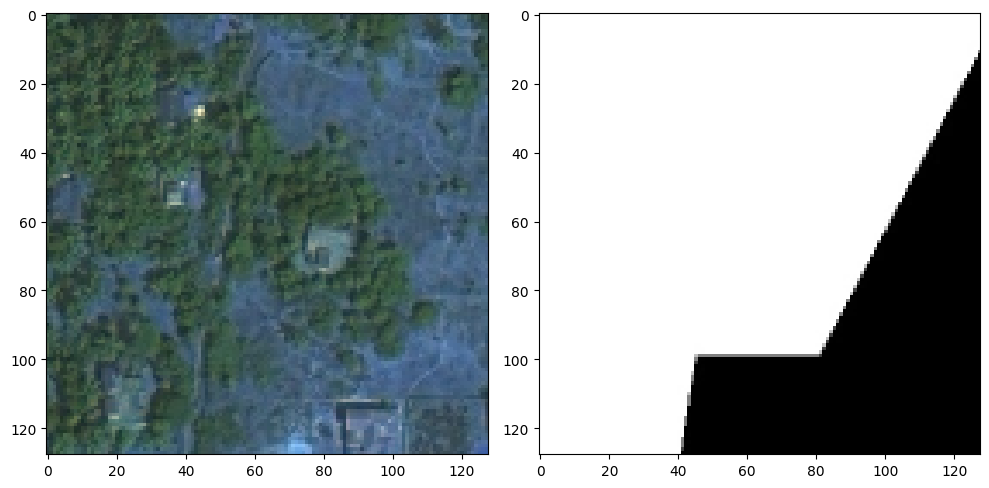

In [23]:
rand_num = random.randint(0,2500)

figure, axes = plt.subplots(1,2, figsize=(10,10))

axes[0].imshow(X[rand_num])

axes[1] = imshow(y[rand_num])

# Training Functions

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69)

This is a function for downward convolution, for the Unet model

In [25]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

This is a function for the upward convolution

In [26]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

And this is the Unet architecture function

In [27]:
def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

# Creating Unet model

In [28]:
model = unet_model(n_filters=32,input_size=(128,128,3))

model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

Below is a summary of the architecture

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

applying an early stopping here so that the model doesn't overfit/underfit

In [30]:
early_stopping_cb = EarlyStopping(patience=8,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("/content/SegmentationModel/model.h5",save_best_only=True)


# Fitting Data

Applying a large number of epoch is fine because the process will stop when the early stopping function detect overfitting/underfitting

In [31]:
num_epochs = 25

history = model.fit(X_train,y_train,epochs=num_epochs,callbacks=[early_stopping_cb], validation_data=(X_test, y_test))

Epoch 1/25
128/128 [==============================] - 61s 278ms/step - loss: 0.6184 - accuracy: 0.6742 - val_loss: 0.5558 - val_accuracy: 0.7373
Epoch 2/25
128/128 [==============================] - 26s 205ms/step - loss: 0.5242 - accuracy: 0.7463 - val_loss: 0.4949 - val_accuracy: 0.7636
Epoch 3/25
128/128 [==============================] - 28s 218ms/step - loss: 0.5032 - accuracy: 0.7577 - val_loss: 0.4672 - val_accuracy: 0.7800
Epoch 4/25
128/128 [==============================] - 27s 210ms/step - loss: 0.4832 - accuracy: 0.7672 - val_loss: 0.4658 - val_accuracy: 0.7799
Epoch 5/25
128/128 [==============================] - 28s 221ms/step - loss: 0.4678 - accuracy: 0.7773 - val_loss: 0.4682 - val_accuracy: 0.7681
Epoch 6/25
128/128 [==============================] - 27s 211ms/step - loss: 0.4578 - accuracy: 0.7834 - val_loss: 0.4441 - val_accuracy: 0.7915
Epoch 7/25
128/128 [==============================] - 28s 221ms/step - loss: 0.4533 - accuracy: 0.7862 - val_loss: 0.4417 - val_ac

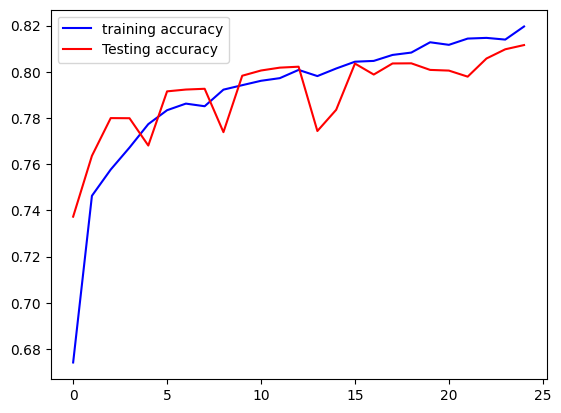

In [32]:
## creating an accuracy graph for training and testing data
plt.plot(history.history['accuracy'],color='blue',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='Testing accuracy')
plt.legend()
plt.show()

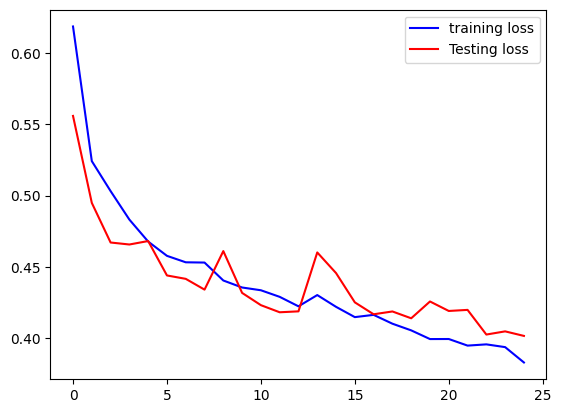

In [33]:
## creating an loss graph for training and testing data
plt.plot(history.history['loss'],color='blue',label='training loss')
plt.plot(history.history['val_loss'],color='red',label='Testing loss')
plt.legend()
plt.show()

From the above loss plot it can be inferred that the model is a relatively good fit. Training loss and testing loss decreases overtime and they are not significantly different to each other by the time the process finishes.

# Evaluation

1/1 [==============================] - 0s 20ms/step


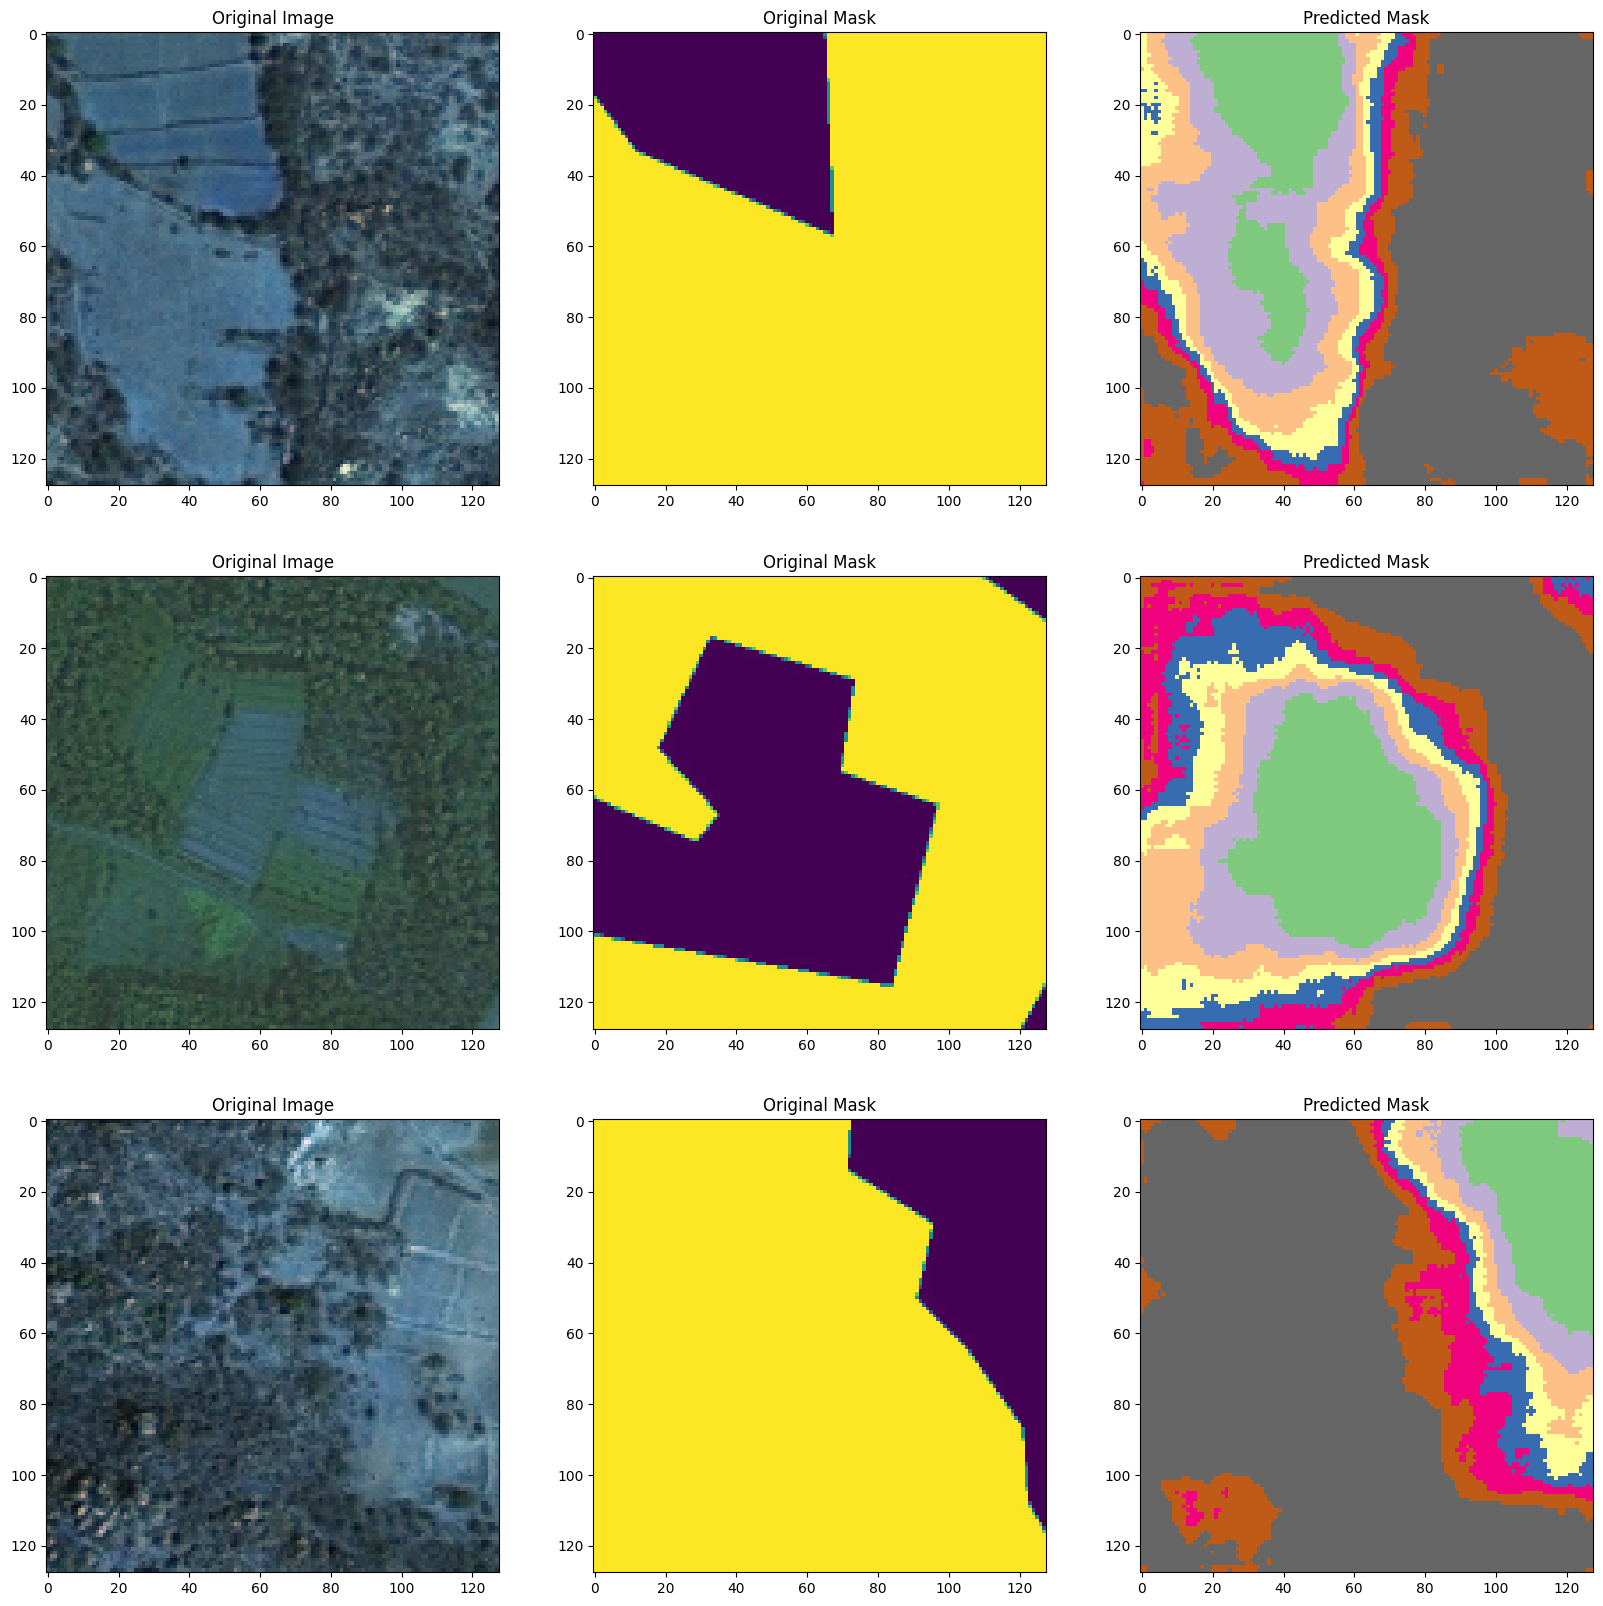

In [34]:
figure, axes = plt.subplots(3,3, figsize=(20,20))

for i in range(0,3):
    rand_num = random.randint(0,50)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')

    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')

    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)
    axes[i,2].imshow(predicted_mask, cmap='Accent')
    axes[i,2].title.set_text('Predicted Mask')

The Unet model does soft attention due to the fact that it analyzes on different subregions of the data. It obtains parameters by doing backpropagation. We can see that the Unet model could predict which area would be affected by a forest fire from the above evaluation picture. It can pin down where the forest is and mask it to predict forest fire.